# ⏰ 시계열 분석 (Time-series Analysis) - 딥러닝 과제

In [1]:
%matplotlib inline

# 시각화 기본 설정
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (6, 3)

# 데이터 분석에 필요한 라이브러리
import pandas as pd
import numpy as np

# PyTorch 관련 라이브러리
import torch
import torch.nn as nn

# 모델 학습 결과를 평가할 때 쓸 통계 라이브러리
from scipy.stats import pearsonr, spearmanr

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
import platform

# 운영체제에 따라 폰트 설정
if platform.system() == 'Windows':
    plt.rc('font', family='Malgun Gothic')  # Windows 전용 폰트
elif platform.system() == 'Darwin':
    plt.rc('font', family='AppleGothic')  # macOS 전용 폰트
else:
    plt.rc('font', family='NanumGothic')  # 리눅스 또는 기타 환경
plt.rc('axes', unicode_minus=False) # 마이너스 기호 깨짐 방지

## 파라미터 세팅

모델 구조, 학습 방식, 데이터 분할 등에 필요한 설정값을 정의합니다.

In [3]:
# 데이터셋 분할 비율 (학습 / 검증 / 테스트)
DATA_SEGMENTS = { 'tr': 0.6, 'va': 0.2, 'tst': 0.2 }

# 학습 조기 종료에 사용할 기준
THRESHOLD_EPOCHS = 2  # 최소 반복 횟수
COR_THRESHOLD = 0.005  # 상관계수 기준 성능 향상 여부 판단

# 입력 시계열 구간 설정
WIN = 24*7      # 입력 시계열 길이 (하루 단위 전력 사용량)
H = 1       # 예측할 시계열 길이

# 모델 구조 설정
MODEL = 'rnn_model'
RNN_UNITS = 128  # RNN의 은닉 노드 수
SEASONAL_PERIOD = 24  # 하루 주기성 반영을 위한 파라미터

# 학습 관련 설정
GPU = 0
BATCH_N = 1024
LR = 0.0001
DROP = 0.2
N_EPOCHS = 30

## 데이터 불러오기

In [4]:
# 데이터 읽어와서 데이터프레임으로 저장
df = pd.read_csv("electricity.txt", header=None)

num_cols = df.shape[1]
df.columns = [f"V{i+1}" for i in range(num_cols)]

df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,14.0,69.0,234.0,415.0,215.0,1056.0,29.0,840.0,226.0,265.0,...,676.0,372.0,80100.0,4719.0,5002.0,48.0,38.0,1558.0,182.0,2162.0
1,18.0,92.0,312.0,556.0,292.0,1363.0,29.0,1102.0,271.0,340.0,...,805.0,452.0,95200.0,4643.0,6617.0,65.0,47.0,2177.0,253.0,2835.0
2,21.0,96.0,312.0,560.0,272.0,1240.0,29.0,1025.0,270.0,300.0,...,817.0,430.0,96600.0,4285.0,6571.0,64.0,43.0,2193.0,218.0,2764.0
3,20.0,92.0,312.0,443.0,213.0,845.0,24.0,833.0,179.0,211.0,...,801.0,291.0,94500.0,4222.0,6365.0,65.0,39.0,1315.0,195.0,2735.0
4,22.0,91.0,312.0,346.0,190.0,647.0,16.0,733.0,186.0,179.0,...,807.0,279.0,91300.0,4116.0,6298.0,75.0,40.0,1378.0,191.0,2721.0


In [5]:
# 차분을 통해 새롭게 데이터프레임 구성
elec = df.diff().iloc[1:].reset_index(drop=True)

In [6]:
elec.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,4.0,23.0,78.0,141.0,77.0,307.0,0.0,262.0,45.0,75.0,...,129.0,80.0,15100.0,-76.0,1615.0,17.0,9.0,619.0,71.0,673.0
1,3.0,4.0,0.0,4.0,-20.0,-123.0,0.0,-77.0,-1.0,-40.0,...,12.0,-22.0,1400.0,-358.0,-46.0,-1.0,-4.0,16.0,-35.0,-71.0
2,-1.0,-4.0,0.0,-117.0,-59.0,-395.0,-5.0,-192.0,-91.0,-89.0,...,-16.0,-139.0,-2100.0,-63.0,-206.0,1.0,-4.0,-878.0,-23.0,-29.0
3,2.0,-1.0,0.0,-97.0,-23.0,-198.0,-8.0,-100.0,7.0,-32.0,...,6.0,-12.0,-3200.0,-106.0,-67.0,10.0,1.0,63.0,-4.0,-14.0
4,-2.0,1.0,-125.0,-6.0,-12.0,-6.0,2.0,-7.0,-2.0,-2.0,...,-5.0,110.0,-4300.0,143.0,-750.0,-11.0,-1.0,-128.0,-6.0,21.0


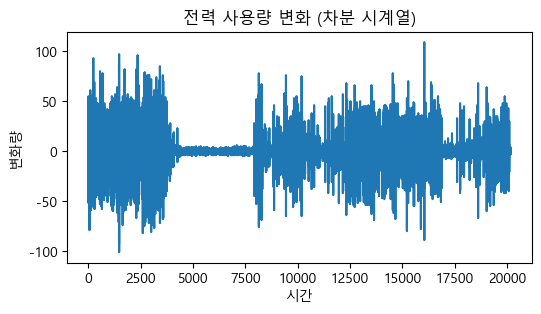

In [7]:
# 전력 사용량의 변화를 시각적으로 확인해봅시다 !
# 데이터는 차분(diff)되어 있어서, 실제 전력 사용량이 아닌 변화량을 가리킵니다.
plt.plot(elec['V1'])
plt.title("전력 사용량 변화 (차분 시계열)")
plt.xlabel("시간")
plt.ylabel("변화량")
plt.show()

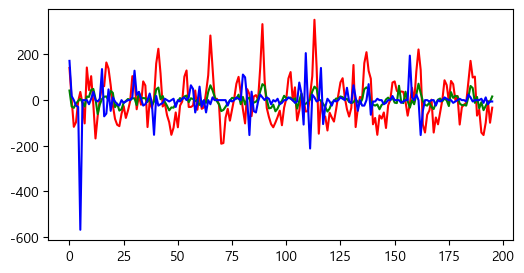

In [8]:
plt.plot(elec.V4[:196], color='r')
plt.plot(elec.V14[:196], color='g')
plt.plot(elec.V114[:196], color='b')
plt.show()

## Dataset 클래스 정의

In [9]:
# PyTorch에서는 Dataset 클래스를 만들어 학습 데이터를 관리합니다.
# 시계열 데이터를 일정 길이(WIN)만큼 슬라이딩 윈도우 방식으로 잘라서
# 입력(X)과 예측 대상(Y)을 만듭니다.

from torch.utils.data import Dataset
import torch

# 딥러닝 세션 복습 ! ***에는 뭐가 들어가야 할까요?
class ElectricityDataset(Dataset):
    def __init__(self, data, win, horizon):
        """
        Args:
            series (np.array): 시계열 데이터.
            win (int): 입력 시계열 길이 (예: 24)
            horizon (int): 예측 시계열 길이 (예: 3)
        """
        super(ElectricityDataset, self).__init__()
        self.series = data
        self.win = win
        self.horizon = horizon

        # 총 데이터 길이(T)
        self.T = data.shape[0]
        # slide 가능한 샘플 개수
        self.n_samples = self.T - self.win - self.horizon + 1

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        start = idx
        end_x = idx + self.win
        end_y = idx + self.win + self.horizon

        X = self.series[start : end_x]
        y = self.series[end_x : end_y, 0]

        X = torch.tensor(X, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)
        return X, y

## 데이터셋 나누기

In [10]:
from torch.utils.data import DataLoader

# 다차원 입력도 가능하지만 이번에는 단일 변수만 사용하겠습니다 !
# 전력 사용량 데이터의 첫 번째 열(V1)을 선택해주세요.
data = elec[['V1']].values

n_total = len(data)
n_train = int(n_total * DATA_SEGMENTS['tr'])
n_val = int(n_total * DATA_SEGMENTS['va'])

train_series = data[:n_train]
val_series = data[n_train: n_train + n_val]
test_series = data[n_train + n_val:]

# 데이터셋 생성
train_dataset = ElectricityDataset(train_series, WIN, H)
val_dataset = ElectricityDataset(val_series, WIN, H)
test_dataset = ElectricityDataset(test_series, WIN, H)

# 데이터를 공급할 DataLoader (배치 단위로)
train_loader = DataLoader(train_dataset, batch_size=BATCH_N, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_N)
test_loader = DataLoader(test_dataset, batch_size=BATCH_N)

데이터셋을 배치로 나눠 모델에 바로 쓸 수 있도록 준비를 마쳤습니다.

## 모델 정의

- **입력**: 과거 `WIN` 시간 동안의 시계열 데이터  
- **출력**: 미래 `H`시간의 시계열 예측값
- **구조**:
  - LSTM 계층: 시계열의 패턴을 기억하고 추론
  - FC 계층: 마지막 hidden state를 기반으로 다수 시점 예측
- **Dropout**: 학습 중 과적합 방지용

이 모델은 입력 시계열의 패턴을 LSTM으로 학습하고,
마지막 시점의 정보를 활용해 미래의 흐름을 예측합니다.

In [11]:
# 시계열 입력을 받아, RNN으로 내부 상태를 업데이트하고,
# 마지막 hidden state를 기반으로 미래 H시간의 값을 예측합니다.

class RNNForecastModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_horizon, dropout=0.2):
        super(RNNForecastModel, self).__init__()
        self.hidden_size = hidden_size
        self.output_horizon = output_horizon

        # LSTM 레이어 적용
        self.rnn = nn.LSTM(input_size=input_size,
                           hidden_size=hidden_size,
                           batch_first=True,
                           dropout=dropout)

        # RNN 출력에서 H개의 시점 예측
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, output_horizon)
        )

    def forward(self, x):
        out, _ = self.rnn(x)

        # 마지막 시점의 hidden state만 사용
        last_hidden = out[:, -1, :]

        # 미래 horizon 값 예측
        y_pred = self.fc(last_hidden)
        return y_pred

In [12]:
# 학습에 사용할 모델을 생성합니다.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = RNNForecastModel(input_size=data.shape[1],
                         hidden_size=RNN_UNITS,
                         output_horizon=H,
                         dropout=DROP).to(device)

In [13]:
# 손실함수: 평균 제곱 오차 (MSE)
criterion = nn.MSELoss()

# 옵티마이저: Adam
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

## 학습

### 모델 학습 과정 요약

- **Train** 단계:
  - 모델이 입력 데이터를 통해 예측값 생성
  - 손실함수로 실제값과 차이를 계산
  - 이 차이를 줄이기 위해 모델의 가중치를 업데이트

- **Validation** 단계:
  - 모델이 학습 데이터 외의 데이터에서도 잘 작동하는지 확인
  - 성능이 개선되지 않으면 학습을 조기 종료

In [14]:
def evaluate(model, data_loader):
    """ 검증 또는 테스트 시 성능 평가 """
    model.eval() # 모델을 평가 모드로 설정 (eval)
    total_loss = 0
    with torch.no_grad():
        for X_batch, Y_batch in data_loader:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            pred = model(X_batch)
            loss = criterion(pred, Y_batch)
            total_loss += loss.item() * X_batch.size(0)
    return total_loss / len(data_loader.dataset)

In [15]:
# 학습 루프 시작
best_val_loss = float('inf')
epochs_no_improve = 0

for epoch in range(N_EPOCHS):
    model.train() # 모델을 학습 모드로 설정 (train)
    running_loss = 0.0

    for X_batch, Y_batch in train_loader:
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)

        # 순전파
        pred = model(X_batch)
        loss = criterion(pred, Y_batch)

        # 역전파 + 최적화
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)

    # 평균 학습 손실
    train_loss = running_loss / len(train_loader.dataset)
    
    # 검증 손실
    val_loss = evaluate(model, val_loader)

    print(f"Epoch {epoch+1}/{N_EPOCHS} - Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")

    # 조기 종료 조건 확인
    if best_val_loss - val_loss < COR_THRESHOLD:
        epochs_no_improve += 1
        if epochs_no_improve >= THRESHOLD_EPOCHS:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break
    else:
        best_val_loss = val_loss
        epochs_no_improve = 0

Epoch 1/30 - Train Loss: 192.117123, Val Loss: 181.348256
Epoch 2/30 - Train Loss: 191.849347, Val Loss: 181.070850
Epoch 3/30 - Train Loss: 191.540508, Val Loss: 180.784306
Epoch 4/30 - Train Loss: 191.249764, Val Loss: 180.476667
Epoch 5/30 - Train Loss: 190.925014, Val Loss: 180.147031
Epoch 6/30 - Train Loss: 190.587976, Val Loss: 179.785239
Epoch 7/30 - Train Loss: 190.140726, Val Loss: 179.367875
Epoch 8/30 - Train Loss: 189.649511, Val Loss: 178.855418
Epoch 9/30 - Train Loss: 189.025088, Val Loss: 178.239693
Epoch 10/30 - Train Loss: 188.240265, Val Loss: 177.476388
Epoch 11/30 - Train Loss: 187.300202, Val Loss: 176.469708
Epoch 12/30 - Train Loss: 185.913360, Val Loss: 175.250706
Epoch 13/30 - Train Loss: 184.405021, Val Loss: 174.191473
Epoch 14/30 - Train Loss: 182.750842, Val Loss: 173.339720
Epoch 15/30 - Train Loss: 181.357059, Val Loss: 172.245788
Epoch 16/30 - Train Loss: 179.779713, Val Loss: 171.772498
Epoch 17/30 - Train Loss: 177.944849, Val Loss: 171.555937
Epoch 

## 예측 및 성능 평가

In [16]:
# 전체 테스트셋에 대해 예측값과 실제값을 저장
model.eval() # 모델을 평가 모드로 설정

y_preds = []
y_trues = []

with torch.no_grad():
    for X_batch, Y_batch in test_loader:
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)

        pred = model(X_batch)

        y_preds.append(pred.cpu().numpy()) # y_preds에 값 추가 (append)
        y_trues.append(Y_batch.cpu().numpy()) # y_trues에 값 추가

# 리스트를 numpy 배열로 결합
y_preds = np.concatenate(y_preds, axis=0)
y_trues = np.concatenate(y_trues, axis=0)

In [17]:
# 전체 시계열 기준으로 flatten (H=3인 경우 각 샘플당 3개의 예측)
y_preds_flat = y_preds.flatten()
y_trues_flat = y_trues.flatten()

In [19]:
# 피어슨 상관계수
pearson_corr, _ = pearsonr(y_trues_flat, y_preds_flat)

# 스피어만 상관계수
spearman_corr, _ = spearmanr(y_trues_flat, y_preds_flat)

print(f"Pearson Correlation:  {pearson_corr:.4f}")
print(f"Spearman Correlation: {spearman_corr:.4f}")

Pearson Correlation:  0.4128
Spearman Correlation: 0.3049


In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def compute_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = mse**0.5
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    return {
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "R2 Score": r2
    }

In [19]:
compute_metrics(y_trues_flat, y_preds_flat)

{'MSE': 64.58625030517578,
 'RMSE': 8.036557117645328,
 'MAE': 3.772688627243042,
 'R2 Score': 0.18540364503860474}

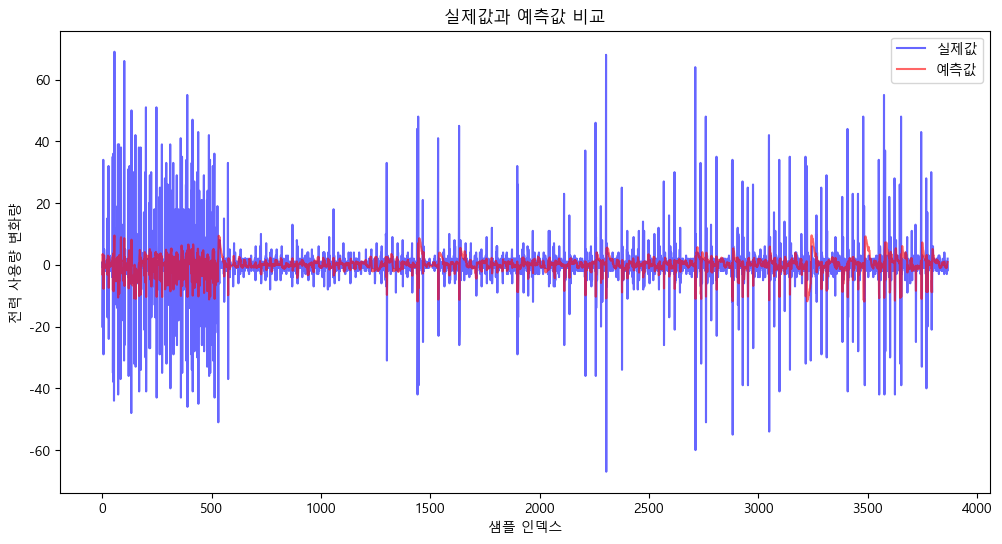

In [21]:
# y_trues와 y_preds를 시각적으로 비교
plt.figure(figsize=(12, 6))
plt.plot(y_trues_flat, label='실제값', color='blue', alpha=0.6)
plt.plot(y_preds_flat, label='예측값', color='red', alpha=0.6)
plt.title('실제값과 예측값 비교')
plt.xlabel('샘플 인덱스')
plt.ylabel('전력 사용량 변화량')
plt.legend()
plt.show()

직접 학습을 시켰기 때문에 모델 성능은 좋지 않지만(🥲), 이런 프로세스로 딥러닝 모델을 시계열 예측에 적용할 수 있다는 것을 확인해 볼 수 있겠습니다 😊

마지막 과제까지 너무 수고하셨습니다 !!